# Variance between replicates is a function of DNA counts and value

Variance dips when DNA count under 20, is this because of samples with 0 RNA counts?

Overall, this seems to point to that we should really be weighting examples by DNA count, not emperical variance?

There is also a strong trend between average of two replicates and the variance between them?
This is likely due to sampling biasses from the RNA-seq procedure. I.e. if have many transcripts more likely to
sample correct proportion.

Conclusion: near the end of this nb is a proceduree for calculating sample weights.
We should try training a model using this weighting system.
We should scale the assay output values prior to calculating these weights, as the variance will obviously change.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

%matplotlib inline

In [2]:
def quantile_plot(data_pairs, quantiles = 5000):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    plt.scatter(avg_activity, avg_score, c = 'r')
    return avg_activity, avg_score

# Variance v. DNA count

In [39]:
dna = open('../data/Scaleup_counts_sequences/DNACOUNTS/ScaleUpDesign1_SV40P_Plasmid.counts')
rna1 = open('../data/Scaleup_counts_sequences/HEPG2/HEPG2_ScaleUpDesign1_SV40P_mRNA_Rep1.counts')
rna2 = open('../data/Scaleup_counts_sequences/HEPG2/HEPG2_ScaleUpDesign1_SV40P_mRNA_Rep2.counts')
dna.readline()
rna1.readline()
rna2.readline()

rep1, rep2, dna_count = [], [], []
total_r_rep1, total_r_rep2, total_d = 0, 0, 0
for d, r1, r2 in zip(dna, rna1, rna2):
    d_name, d_val   =  d.strip().split()
    r1_name, r1_val = r1.strip().split()
    r2_name, r2_val = r2.strip().split()
    assert d_name == r1_name == r2_name
    d_val, r1_val, r2_val = map(float, [d_val, r1_val, r2_val])
    if d_val < 500: continue
    rep1 += [log(r1_val + 1, 2) - log(d_val + 1, 2)]
    rep2 += [log(r2_val + 1, 2) - log(d_val + 1, 2)]
    dna_count += [d_val]
    
    total_r_rep1 += r1_val + 1
    total_r_rep2 += r2_val + 1
    total_d += d_val + 1
    
rep1 = map(lambda x: x + log(total_d, 2) - log(total_r_rep1, 2), rep1)
rep2 = map(lambda x: x + log(total_d, 2) - log(total_r_rep2, 2), rep2)

print len(rep1)

6527


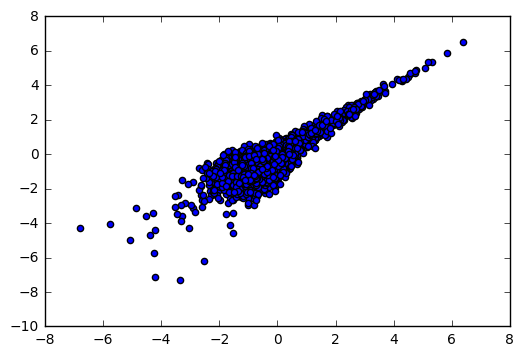

In [40]:
plt.scatter(rep1, rep2)
plt.show()

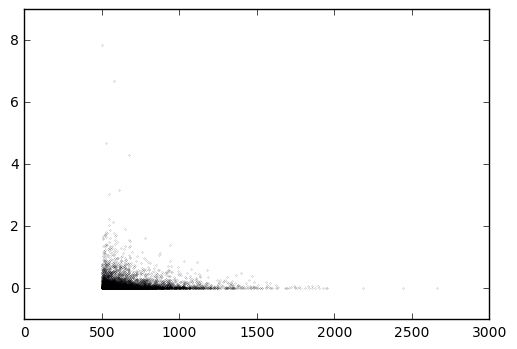

In [41]:
variance = [(r1 - r2)**2 / 2 for r1, r2 in zip(rep1, rep2)]
plt.scatter(dna_count, variance, s = .01)
plt.show()

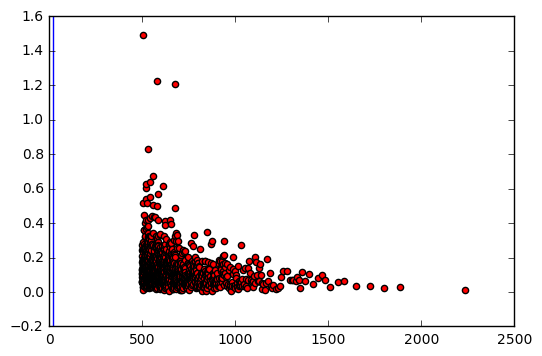

In [42]:
quantile_plot(zip(dna_count, variance), 1000)
plt.axvline(20)
plt.show()

# Activity is a fxn of DNA count???

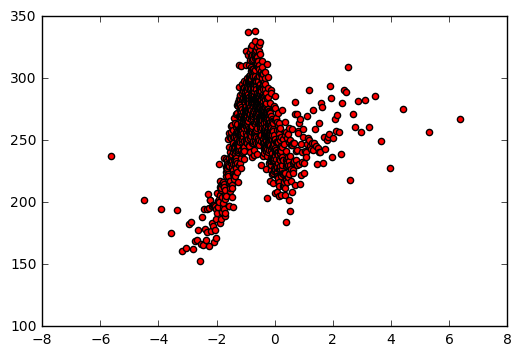

In [16]:
#plt.scatter([(r1+r2) / 2 for r1, r2 in zip(rep1, rep2)], dna_count)
quantile_plot(zip([(r1+r2) / 2 for r1, r2 in zip(rep1, rep2)], dna_count), 1000)
plt.show()

# Variance as a fxn of average

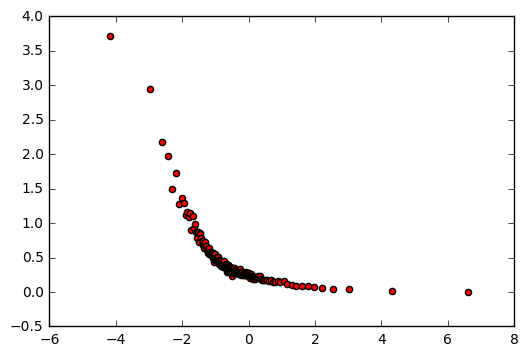

In [17]:
#plt.scatter([(r1+r2) / 2 for r1, r2 in zip(rep1, rep2)], variance, s = .01)
quantile_plot(zip([(r1+r2) / 2 for r1, r2 in zip(rep1, rep2)], variance), 200)
plt.show()

# Produce Weights

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array([dna_count, [(r1+r2) / 2 for r1, r2 in zip(rep1, rep2)]]).T)
y = np.array(variance)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [RandomForestRegressor(max_depth = 15), RandomForestRegressor(max_depth = 10),
          RandomForestRegressor(max_depth = 5), RandomForestRegressor(),
          KNeighborsRegressor(n_neighbors = 500), KNeighborsRegressor(n_neighbors = 200),
          KNeighborsRegressor(n_neighbors = 100), KNeighborsRegressor(n_neighbors = 50),
          KNeighborsRegressor(n_neighbors = 10),
         ]

for model in models:
    model.fit(X_train, y_train)
    print model.score(X_test, y_test)

0.28526232361
0.299593090722
0.285804309548
0.207250814043
0.299926990097
0.29904215313
0.297876273902
0.292576535573
0.273800906667


0.302408039816


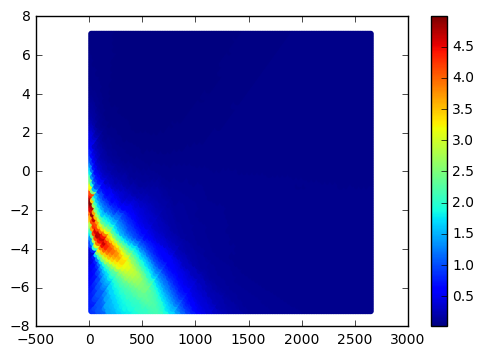

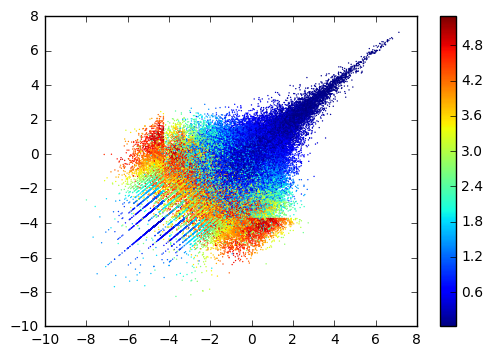

In [20]:
best_model = KNeighborsRegressor(n_neighbors = 500).fit(X, y)
print best_model.score(X, y)
dna = list(np.arange(np.min(X[:, 0]), np.max(X[:, 0]), .1))
avg = list(np.arange(np.min(X[:, 1]), np.max(X[:, 1]), .1))
X_e = np.array([dna * len(avg), avg * len(dna)]).T

unscaled_X_e = scaler.inverse_transform(X_e)
sc = plt.scatter(unscaled_X_e[:, 0], unscaled_X_e[:, 1], c = best_model.predict(X_e), lw = 0)
plt.colorbar(sc)
plt.show()

weights = map(lambda x: 1 / x, best_model.predict(X))
sc = plt.scatter(rep1, rep2, c = best_model.predict(X), s = 1, lw = 0)
plt.colorbar(sc)
plt.show()